In [1]:
from __future__ import print_function, division

from torchvision import models, datasets, transforms
import torchvision
import torch.nn as nn
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()
%matplotlib inline

### Load data

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) 
                for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Visualize a few images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


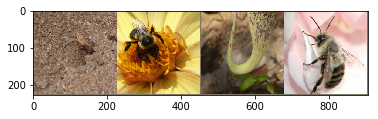

In [3]:
inputs, classes = next(iter(data_loaders['train']))
def imshow(inputs):
    out = torchvision.utils.make_grid(inputs)
    out = out.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    out = std * out + mean
    plt.imshow(out)
    
imshow(inputs)

### Traning the model

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    
    losses = {'train': [], 'val': []}
    accs = {'train': [], 'val': []}

    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {} / {}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            accs[phase].append(epoch_acc)
            
            print('{} Loss: {:4f} Acc: {:4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model, losses, accs


### Fine tuning Resnet50

In [5]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=num_ftrs, out_features=2, bias=True)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### Train and evaluate

In [6]:
model, losses, accs = train_model(model, criterion, optimizer, exp_lr_scheduler, 250)

Epoch 1 / 250
----------
train Loss: 0.553730 Acc: 0.745902
val Loss: 0.287256 Acc: 0.882353

Epoch 2 / 250
----------
train Loss: 0.467322 Acc: 0.807377
val Loss: 0.311455 Acc: 0.888889

Epoch 3 / 250
----------
train Loss: 0.535624 Acc: 0.766393
val Loss: 0.260967 Acc: 0.888889

Epoch 4 / 250
----------
train Loss: 0.381003 Acc: 0.852459
val Loss: 0.207980 Acc: 0.908497

Epoch 5 / 250
----------
train Loss: 0.426932 Acc: 0.807377
val Loss: 0.258120 Acc: 0.921569

Epoch 6 / 250
----------
train Loss: 0.527194 Acc: 0.790984
val Loss: 0.623199 Acc: 0.764706

Epoch 7 / 250
----------
train Loss: 0.450549 Acc: 0.803279
val Loss: 0.366111 Acc: 0.908497

Epoch 8 / 250
----------
train Loss: 0.225415 Acc: 0.913934
val Loss: 0.305579 Acc: 0.915033

Epoch 9 / 250
----------
train Loss: 0.300773 Acc: 0.901639
val Loss: 0.260406 Acc: 0.921569

Epoch 10 / 250
----------
train Loss: 0.324417 Acc: 0.840164
val Loss: 0.289593 Acc: 0.908497

Epoch 11 / 250
----------
train Loss: 0.237494 Acc: 0.91393

### Plot training/val curves

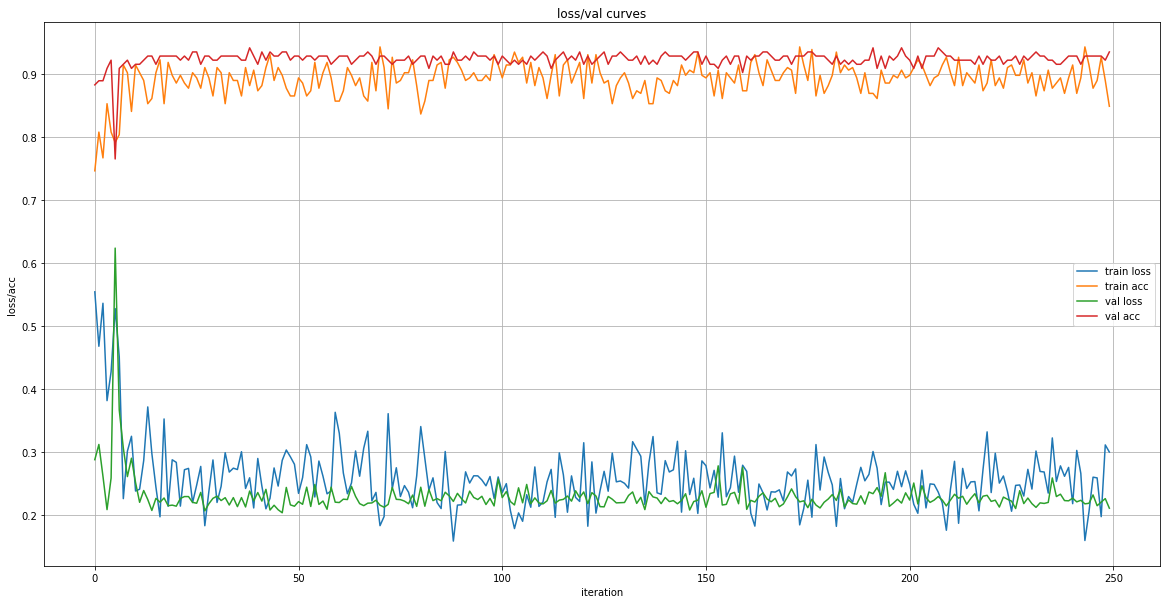

In [7]:
plt.figure(figsize=(20, 10))

for phase in ['train', 'val']:
    plt.plot(losses[phase], label='{} loss'.format(phase))
    plt.plot(accs[phase], label='{} acc'.format(phase))

plt.legend()

plt.title('loss/val curves')

plt.xlabel('iteration')
plt.ylabel('loss/acc')

plt.grid(True)